A notebook for testing code while developing aperinfo

In [1]:
from __future__ import print_function

In [4]:
import sys
#sys.path.append('/home/adams/atdbquery')
#import atdbquery
from astropy.table import Table
import numpy as np
from astropy.io import ascii
from datetime import datetime

In [5]:
import matplotlib.pyplot as plt
from kapteyn import maputils
from functions.utilities import get_survey_ra_dec
import os
import numpy as np

In [6]:

#get mpl colors
prop_cycle = plt.rcParams['axes.prop_cycle']
mpcolors = prop_cycle.by_key()['color']

surveypointings = os.path.join(
                            'files',
                            'all_pointings.v7.18jun20.txt')

In [16]:
#I want to look at continuum validation and understand how often different criteria matter
cont_valid = ascii.read('files/cont_allbeams.csv')
#cont_valid
combine_valid = ascii.read('files/combined_valid.csv')
good_inds = np.where(combine_valid['pol_bmin'] > 0)[0]
print(good_inds)
combine_valid = combine_valid[good_inds]
combine_valid

[ 200  201  202 ... 9957 9958 9959]


taskid,beam,cont_pass,pol_pass,pol_V_pass,pol_QU_pass,HI_all_good,HI_all_good_ok,HI_c2_good_ok,HI_c2_good,HI_pass,all_pass,s_in,s_out,rat,N2,Ex-2,pol_s_in,pol_s_out,pol_rat,pol_peak,pol_peak_s,pol_N2,pol_P2,pol_Ex-2,pol_Ex+2,pol_ftmax,pol_peak_in,pol_bmin,pol_bmaj,pol_bpa,Q_bm_fg,U_bm_fg,Q_st_fg,U_st_fg,c2,c1,c0,rms_c2,rms_c1,rms_c0,lgfrac_c2,lgfrac_c1,lgfrac_c0,prom_c2,prom_c1,prom_c0
int64,int64,str5,str5,str5,str5,str5,str5,str5,str5,str5,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64
190711169,0,False,False,True,False,None,None,None,None,None,None,53.5,34.2,1.57,4.6,1101.0,49.1,33.0,1.49,1766.5,53.5,3.2,3.2,2498.0,2511.0,9.7,1766.5,12.1,21.6,0.4,1.0,1.0,1.0,1.0,N,N,N,nan,nan,nan,nan,nan,nan,nan,nan,nan
190711169,1,True,False,True,False,None,None,None,None,None,None,51.8,47.3,1.1,1.5,147.0,47.5,46.3,1.03,548.8,11.9,1.1,1.1,874.0,847.0,7.4,548.8,12.0,21.9,0.7,1.0,1.0,1.0,1.0,N,N,N,nan,nan,nan,nan,nan,nan,nan,nan,nan
190711169,2,False,False,False,False,None,None,None,None,None,None,78.8,70.9,1.11,1.7,211.0,72.6,69.6,1.04,2760.4,39.6,1.1,1.1,869.0,877.0,10.5,2760.4,12.0,22.1,0.5,1.0,1.0,1.0,1.0,N,N,N,nan,nan,nan,nan,nan,nan,nan,nan,nan
190711169,3,True,False,True,False,None,None,None,None,None,None,39.8,35.5,1.12,1.6,176.0,34.3,34.0,1.01,1157.8,34.0,1.0,1.0,746.0,752.0,5.2,885.2,12.0,22.1,0.3,1.0,1.0,1.0,1.0,N,N,N,nan,nan,nan,nan,nan,nan,nan,nan,nan
190711169,4,False,False,False,False,None,None,None,None,None,None,188.2,152.6,1.23,2.5,465.0,192.9,146.7,1.31,10205.2,69.6,1.7,1.7,1279.0,1283.0,91.1,10205.2,12.0,22.0,0.3,1.0,1.0,1.0,1.0,N,N,N,nan,nan,nan,nan,nan,nan,nan,nan,nan
190711169,5,True,False,True,False,None,None,None,None,None,None,44.9,39.1,1.15,1.8,256.0,40.4,35.9,1.13,3508.3,97.7,1.1,1.1,878.0,829.0,9.2,3508.3,12.0,22.1,0.3,1.0,1.0,1.0,1.0,N,N,N,nan,nan,nan,nan,nan,nan,nan,nan,nan
190711169,6,True,False,True,False,None,None,None,None,None,None,50.8,43.6,1.16,2.0,298.0,41.5,40.8,1.02,1109.9,27.2,1.0,1.0,803.0,782.0,5.8,1109.9,12.0,22.2,0.3,1.0,1.0,1.0,1.0,N,N,N,nan,nan,nan,nan,nan,nan,nan,nan,nan
190711169,7,False,False,False,False,None,None,None,None,None,None,116.8,87.4,1.34,3.2,679.0,85.6,80.1,1.07,2042.0,25.5,1.3,1.3,1019.0,999.0,46.4,1919.7,12.0,22.1,0.4,1.0,1.0,1.0,1.0,N,N,N,nan,nan,nan,nan,nan,nan,nan,nan,nan
190711169,8,True,False,True,False,None,None,None,None,None,None,47.5,42.1,1.13,1.7,206.0,42.3,41.1,1.03,930.7,22.7,1.1,1.1,876.0,867.0,5.7,930.7,12.0,21.9,0.2,1.0,1.0,1.0,1.0,N,N,N,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [27]:
#goes a bit beyond data release, but not terribly, so will use it for now
#get true/false for each criterion
true_array = np.full(len(combine_valid),'True')
false_array = np.full(len(combine_valid),'False')
crit_noise = np.where(combine_valid['s_in']<60., true_array, false_array) 
crit_res = np.where(combine_valid['pol_bmin'] < 16., true_array, false_array) #i actually don't have this information - would have to 
crit_rat = np.where(combine_valid['rat'] < 1.225, true_array, false_array)
#crit_complex = np.where((combine_valid['rat'] < 1.15) or (combine_valid['rusc-'] < 4.5) or (), true_array, false_array)
# bleh I don't have this criteria - missing rusc- (have to remake table)
#but can see if there is anything that passes the other three but is failed overall!!
#which is what I really care about
pass_3 = np.full(len(combine_valid), 'False')
fail_on_complex = np.full(len(combine_valid), 'False')
pass_survey_spec = np.full(len(combine_valid),'False')
fail_rat = np.full(len(combine_valid),'False')
for i in range(len(combine_valid)):
    if ( (crit_noise[i] == 'True') and (crit_res[i] == 'True') and 
        (crit_rat[i] == 'True') ):
        pass_3[i] = 'True'
        if combine_valid['cont_pass'][i] == 'False':
            fail_on_complex[i] = 'True'
    if ((crit_noise[i] == 'True') and (crit_res[i] == 'True')):
        pass_survey_spec[i] = 'True'
        if crit_rat[i] == 'False':
            fail_rat[i] = 'True'


In [31]:
fail_on_complex
inds = np.where(fail_on_complex == 'True')[0]
print(len(inds))
print(len(inds)/len(combine_valid))

223
0.023865582191780824


In [32]:
#so it matters, but only in a tiny amount of cases
#how often does rat value catch things?
#compraed to failing either noise or res?
#note that noise criteria is already catching a lot of artifacts because that increases the noise in inner region.
#addt hat as note to paper?
fail_rat
inds_rat = np.where(fail_rat == 'True')[0]
print(len(inds_rat))
print(len(inds_rat)/len(combine_valid))

2585
0.2766481164383562


In [ ]:
#inds_spec = np.where()

In [4]:
dec0 = 89.9999999999   # Avoid plotting on the wrong side
header = {'NAXIS'  :  2,
          'NAXIS1' :  40, 'NAXIS2': 40,
          'CTYPE1' : 'RA---ARC',
          'CRVAL1' :  0.0, 'CRPIX1' : 20, 'CUNIT1' : 'deg',
          'CDELT1' : -5.0, 'CTYPE2' : 'DEC--ARC',
          'CRVAL2' :  dec0, 'CRPIX2' : 20,
          'CUNIT2' : 'deg', 'CDELT2' : 5.0,
         }

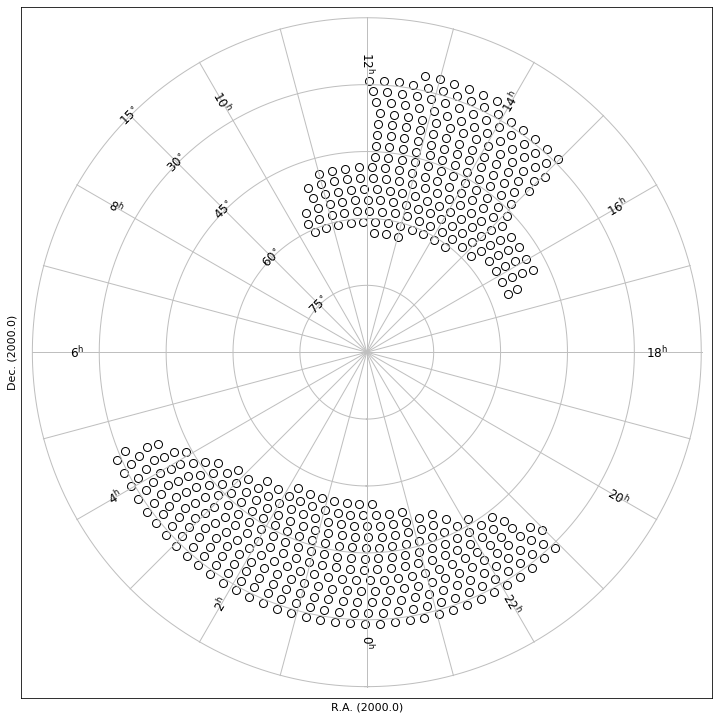

In [69]:

#figure instance
fig = plt.figure(figsize=(12,12))
frame = fig.add_axes((0.1,0.1,0.8,0.8))
f = maputils.FITSimage(externalheader=header)

f.set_limits(pxlim = (5,35), pylim=(5,35))

X = np.arange(0,360,15)
Y = np.arange(15,90, 15) 


lon_world = np.arange(0,360,30)
lat_world = np.arange(15,90,15) #[20, 30, 60, 90]
lon_constval = 9*15
lat_constval = 25



annim = f.Annotatedimage(frame)
grat = annim.Graticule(axnum=(1,2),wylim=(15.0,90.0), wxlim=(0,360),
                       startx=X, starty=Y)

grat.setp_gratline(color='0.75')
    
grat.setp_lineswcs1(20, color='g', linestyle='--')

# Plot labels inside the plot
lon_kwargs = {'color':'k', 'fontsize':12}
lat_kwargs = {'color':'k', 'fontsize':12}
grat.Insidelabels(wcsaxis=0,
                  world=lon_world, constval=lat_constval,
                  fmt="Hms",
                  **lon_kwargs)
grat.Insidelabels(wcsaxis=1,
                  world=lat_world, constval=lon_constval,
                  fmt="Dms",
                  **lat_kwargs)

#set marker size
ms = 8

sra, sdec = get_survey_ra_dec(surveypointings)
xs,ys = annim.topixel(sra,sdec)
annim.Marker(x=xs,y=ys,
             marker='o',mode='pixel',markersize=ms,
             color='black',fillstyle='none')
annim.plot()

In [3]:
obslist = atdbquery.atdbquery('imaging',False,False)

Total number of results found in ATDB for IMAGING: 13603
Processing page 1...
Processing page 2...
Processing page 3...
Processing page 4...
Processing page 5...
Processing page 6...
Processing page 7...
Processing page 8...
Processing page 9...
Processing page 10...
Processing page 11...
Processing page 12...
Processing page 13...
Processing page 14...
Processing page 15...
Processing page 16...
Processing page 17...
Processing page 18...
Processing page 19...
Processing page 20...
Processing page 21...
Processing page 22...
Processing page 23...
Processing page 24...
Processing page 25...
Processing page 26...
Processing page 27...
Processing page 28...
Processing page 29...
Processing page 30...
Processing page 31...
Processing page 32...
Processing page 33...
Processing page 34...
Processing page 35...
Processing page 36...
Processing page 37...
Processing page 38...
Processing page 39...
Processing page 40...
Processing page 41...
Processing page 42...
Processing page 43...
Proces

In [10]:
fulltable = Table(obslist)
ind_long = np.where(fulltable['duration'] >= 36000.)[0]
targettable = fulltable[ind_long]
targettable.sort('taskID')
print(targettable)

      beamPattern         beams  ...  timestamp_running    timestamp_starting 
------------------------ ------- ... -------------------- --------------------
square_39p1_8bit_37beams   0..39 ...                 None                 None
square_39p1_8bit_37beams   0..39 ...                 None                 None
  hybridXX_20180928_8bit   0..39 ...                 None                 None
square_39p1_8bit_37beams   0..39 ...                 None                 None
square_39p1_8bit_37beams   0..39 ...                 None                 None
square_39p1_8bit_37beams   0..39 ...                 None                 None
square_39p1_8bit_37beams   0..39 ...                 None                 None
square_39p1_8bit_37beams   0..39 ...                 None                 None
square_39p1_8bit_37beams   0..39 ...                 None                 None
square_39p1_8bit_37beams   0..39 ...                 None                 None
                     ...     ... ...                

In [21]:
surveyinds = []
otherinds = []
testinds = []
earlyscienceinds = []
argoinds = []
for i,(name,taskid) in enumerate(zip(targettable['name'],targettable['taskID'])):
    #first grab specific fields that I know are tests
    if (taskid == '191030203'):
        testinds.append(i)
    #find ARGO fields
    elif name[0:4] == 'ARGO':
        argoinds.append(i)
    #find early science fields based on date
    elif (int(taskid) < 190702000) and (int(taskid) > 190409000):
        earlyscienceinds.append(i)
    #find survey fields based on name length and date
    elif (len(name) == 10) and (int(taskid) > 190702000):
        surveyinds.append(i)
    #dump everything else somewhere
    else:
        otherinds.append(i)
        
surveyfields = targettable[surveyinds]
otherfields = targettable[otherinds]
earlysciencefields = targettable[earlyscienceinds]
argofields = targettable[argoinds]

print(surveyfields['taskID','name','field_ra','field_dec',
                             'telescopes','duration','quality','beamPattern'])
print(argoinds['taskID','name','field_ra','field_dec',
                             'telescopes','duration','quality','beamPattern'])
print(earlysciencefields['taskID','name','field_ra','field_dec',
                             'telescopes','duration','quality','beamPattern'])



  taskID     name     field_ra  field_dec ... duration quality beamPattern
--------- ---------- ---------- --------- ... -------- ------- -----------
190711169 S2152+4114    328.125 41.240833 ...    41400    good square_39p1
190712041 M1403+5324     210.85 53.401389 ...    41400    good square_39p1
190713001 M0155+3130  28.829167   31.5125 ...    41400    good square_39p1
190713042 S2323+2904 350.933333 29.080278 ...    41400    good square_39p1
190714041 S1444+5058   221.0625 50.969167 ...    41400    good square_39p1
190718124 S2146+4340 326.516667 43.673056 ...    41400    good square_39p1
190719041 S1242+5058      190.7 50.969167 ...    41400    good square_39p1
190719042 M0155+3130  28.829167   31.5125 ...    41400    good square_39p1
190720041 S2336+2904 354.091667 29.080278 ...    41400    good square_39p1
190721041 S1426+5058    216.725 50.969167 ...    41400    good square_39p1
      ...        ...        ...       ... ...      ...     ...         ...
200331017 S2235+4832   33

In [23]:
#can I write a subset of colums out?
ascii.write(surveyfields['taskID','name','field_ra','field_dec',
                             'telescopes','duration','quality','beamPattern'],
           'obsinfo.csv',format='csv')

In [26]:
print(datetime.today().strftime('%Y-%m-%d'))

20200424
